## 1. Test Moriarty's method yourself

In [2]:


def gene_score(lst, base_1,base_2,weight):
    """
    This function counts the number of A/T or G/C in a read
    and calculates a score based on the input weight.
    """
    count = 0
    for ele in lst:
        if (ele == base_1 or ele == base_2 ):
            count = count + 1
    return count * weight

def get_score_frequencies(fa_filename):
    """
    This function iterates through each read in .fa files
    and returns the frequencies of scores as defined by the Moriarty 
    machine learning algorithm
    """
    score_list = []
    for line_num, line in enumerate(open(fa_filename)): 

        line = line.rstrip('\n')       
        # only append lines to the list if it doesn't start with '#' and if it is not in the bad lines
        if (line[0] != '>'): 
            
            fields = [i for i in line]  # Split line into fields

            gene_score(fields,'A','T',-1) + gene_score(fields,'C','G',1)
      
            score_list.append(gene_score(fields,'A','T',-1) + gene_score(fields,'C','G',1))

    return score_list


pathogen_score_freq = get_score_frequencies('pathogen.fa')
sandmouse_score_freq = get_score_frequencies('sandmouse.fa')

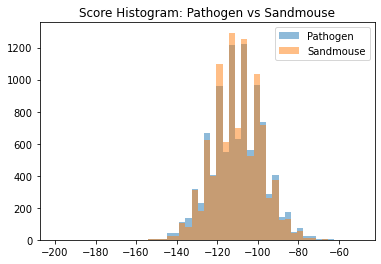

In [124]:
import numpy as np
from matplotlib import pyplot
import matplotlib as mpl
bins = np.linspace(-200,-50, 50)

pyplot.hist(pathogen_score_freq, bins, alpha=0.5, label='Pathogen')
pyplot.hist(sandmouse_score_freq, bins, alpha=0.5, label='Sandmouse')
pyplot.legend(loc='upper right')
pyplot.title('Score Histogram: Pathogen vs Sandmouse')
mpl.rcParams['figure.facecolor'] = 'white'
pyplot.show()

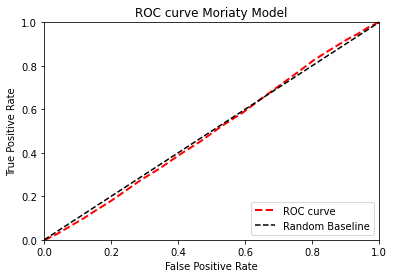

In [18]:
y = np.concatenate((np.zeros(10000),np.ones(10000)),axis = 0)
thresholds = np.linspace(-160,-60, 500)
score = pathogen_score_freq + sandmouse_score_freq

# false positive rate
FPR_1 = []
# true positive rate
TPR_1 = []

"""
For each threshold, count up the true positives and 
false positives base on if each score is >= threshold.
Append the calculated the false positive and true positive rate to the lists
that countain all true positive rates and the list that contains all false positive rates
"""


for thresh in thresholds:
    FP=0
    TP=0
    thresh = round(thresh,2) 
    for i in range(len(score)):
        if (score[i] >= thresh):
            if y[i] == 1:
                TP = TP + 1
            if y[i] == 0:
                FP = FP + 1
    FPR_1.append(FP/10000)
    TPR_1.append(TP/10000)
    
pyplot.plot(FPR_1, TPR_1, linestyle='--', color='red', lw = 2, label='ROC curve', clip_on=False)
pyplot.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Baseline')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC curve Moriaty Model')
pyplot.legend(loc="lower right")
pyplot.show()

### We observe from the above histogram that the two histograms fully overlaps in the -60  to -150 score region. Morover, from the ROC curve plot, we observe that our classification of the two groups is basically as good as flipping a fair coin because our ROC curve almost perfectly overlaps with the theoritical 50% AUC line. I conclude that Moriarty's algorithm is incapable of distingushing between Pathogen sequences and Sandmouse sequences. 

## 2. Make your own method


In [5]:
def read_fa(fa_filename):
    """
    This function reads in all the sequences given a fasta file
    """
    total_data = []
    for line_num, line in enumerate(open(fa_filename)): 

            line = line.rstrip('\n')       
            # only append lines to the list if it doesn't start with '#' and if it is not in the bad lines
            if (line[0] != '>'): 
                
                fields = [i for i in line]  # Split line into fields
                total_data.append(fields)

    return total_data

pathogen_fa = np.array(read_fa('pathogen.fa'))
sandmouse_fa = np.array(read_fa('sandmouse.fa'))

 

In [111]:
import pandas as pd

# We will use the first 5000 sequences as train
# Pathogen_fa and sandmouse_fa have been randomly shuffled
np.random.shuffle(pathogen_fa)
pathogen_train = pathogen_fa[0:5000,:]
np.random.shuffle(sandmouse_fa)
sandmouse_train = sandmouse_fa[0:5000,:]

def populate_transition_matrix(train_fa):
    """
    This function trains a second order Markov model
    on a given training set of sequences by populating the transition matrix.
    the p_A through p_C columns contain conditional probabilities e.g. p(A | AT)
    """

    current_state = ['AA','AT','AG','AC','TT','TG','TC','TA','GG','GC','GA','GT','CC','CA','CT','CG']
    future_state = ['A', 'T', 'G','C']
    transition_matrix = pd.DataFrame(np.zeros((16, 4)),index = current_state,columns = future_state)

    for seq in range(0,train_fa.shape[0]):
        for base in range(2,train_fa.shape[1]):
            x = train_fa[seq,base]
            x_1 = train_fa[seq,base - 2]
            x_2 = train_fa[seq,base - 1]
            transition_matrix.loc[x_1+x_2,x] = transition_matrix.loc[x_1+x_2,x] + 1
    # Calculating the row sum of counts
    transition_matrix['row_sum'] = transition_matrix.sum(axis=1)
    # Calculating conditional probability p(x|xx)
    transition_matrix['p_A'] = transition_matrix['A'] / transition_matrix['row_sum']
    transition_matrix['p_T'] = transition_matrix['T'] / transition_matrix['row_sum']
    transition_matrix['p_G'] = transition_matrix['G'] / transition_matrix['row_sum']
    transition_matrix['p_C'] = transition_matrix['C'] / transition_matrix['row_sum'] 
    transition_matrix['p_marginal'] = transition_matrix['row_sum'] / sum(transition_matrix['row_sum'])
    transition_matrix.drop(future_state + ['row_sum'], axis =1,inplace = True) 

    return transition_matrix

pathogen_transition_matrix = populate_transition_matrix(pathogen_train)
sandmouse_transition_matrix = populate_transition_matrix(sandmouse_train)
        

In [125]:
pathogen_transition_matrix

,p_A,p_T,p_G,p_C,p_marginal
AA,0.480678,0.353071,0.090859,0.075392,0.171683
AT,0.357194,0.419684,0.106830,0.116292,0.143795
AG,0.449515,0.228292,0.153346,0.168847,0.043007
AC,0.417287,0.332402,0.090239,0.160073,0.029999
TT,0.296629,0.483841,0.103071,0.116459,0.170962
TG,0.324435,0.289997,0.202497,0.183071,0.042794
TC,0.306140,0.424880,0.048677,0.220304,0.045341
TA,0.401345,0.397936,0.117088,0.083632,0.127712
GG,0.551179,0.229315,0.110648,0.108859,0.018641
GC,0.426885,0.391695,0.078880,0.102539,0.018658


### The pathogen trainsition matrix above shows the populated conditional probabilities computed from pathegon.fa. We now have "trained" the models.

In [112]:

def get_log_odds(sequence,model_1,model_2):
    """
    The function gets the log_odds score by plugging in the conditional probabilities and marginal probabilities
    from the populated transition matrices to the second order Markov Chain formula. In more detail, for a given sequence, the function
    first checks the inital two bases and finds the marginal probabilities of getting those two bases in the 'p_marginal' column (e.g. p(AT)),
    and the algorithm then slides down to the next base and get the conditional probability of having that base given its previous
    two bases (e.g. p(G|AT)). The algorithm then continues to slide down a sequence until it reaches the end. All of probabilities it extracted
    in this process are stored in model_1_log_probs and model_2_log_probs respectively. We then use these two lists of log probabilities to 
    calculate the log odds score.
    """

    model_1_log_probs = []
    model_2_log_probs = []
    conditioned_pair = "".join(sequence[0:2])
    model_1_log_probs.append(np.log(model_1.loc[conditioned_pair,'p_marginal']))
    model_2_log_probs.append(np.log(model_2.loc[conditioned_pair,'p_marginal']))
    for base in range(2,len(sequence)):
        if base != 2:
            conditioned_pair = (sequence[base-2]) + (sequence[base-1])
        model_1_log_probs.append(np.log(model_1.loc[conditioned_pair,'p_'+sequence[base]]))
        model_2_log_probs.append(np.log(model_2.loc[conditioned_pair,'p_'+sequence[base]]))
    llr = sum(model_1_log_probs) - sum(model_2_log_probs)
    return llr
    


# Taking the last 5000 sequences from pathogen_fa and sandmouse_fa as test so there is no leakage!
test = np.concatenate((pathogen_fa[5000:,:],sandmouse_fa[5000:,:]),axis=0)
def get_all_log_odds_score(test,model_1,model_2):
    """
    This function gets all of the log odds score from the two models by
    calling the get_log_odds
    """
    all_log_odds = []
    for seq in test:
        all_log_odds.append(get_log_odds(sequence = seq,model_1 = model_1,model_2 = model_2))
    return all_log_odds


all_log_odds = get_all_log_odds_score(test,pathogen_transition_matrix,sandmouse_transition_matrix)





        


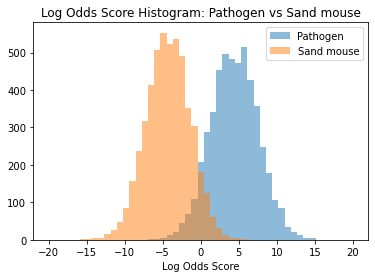

In [113]:
bins = np.linspace(-20,20, 50)
pyplot.hist(all_log_odds[0:5000], bins, alpha=0.5, label='Pathogen')
pyplot.hist(all_log_odds[5000:10000], bins, alpha=0.5, label='Sand mouse')
pyplot.legend(loc='upper right')
pyplot.xlabel('Log Odds Score')
pyplot.title('Log Odds Score Histogram: Pathogen vs Sand mouse')
mpl.rcParams['figure.facecolor'] = 'white'
pyplot.show()



### From the histograms of the log odds scores of pathogen vs sand mouse, we can see that the two histograms are no longer fully overlapping compared to the histograms of the scores from Moriarty's algorithm. The two histograms of log odds scores appear to have a certain degree of distinct seperation with only little overlap.

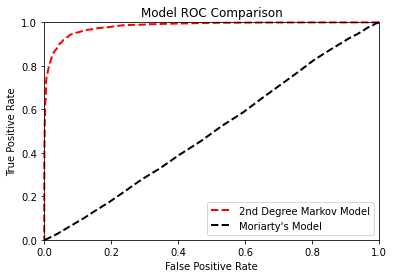

In [126]:
y = np.concatenate((np.ones(5000),np.zeros(5000)),axis = 0)
thresholds = np.linspace(-16,16, 500)


# false positive rate
FPR = []
# true positive rate
TPR = []

for thresh in thresholds:
    FP=0
    TP=0
    thresh = round(thresh,2) 
    for i in range(len(all_log_odds)):
        if (all_log_odds[i] >= thresh):
            if y[i] == 1:
                TP = TP + 1
            if y[i] == 0:
                FP = FP + 1
    FPR.append(FP/5000)
    TPR.append(TP/5000)
    
pyplot.plot(FPR, TPR, linestyle='--', color='red', lw = 2, label='2nd Degree Markov Model', clip_on=False)
pyplot.plot(FPR_1, TPR_1, linestyle='--', color='black', lw = 2, label="Moriarty's Model", clip_on=False)
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Model ROC Comparison')
pyplot.legend(loc="lower right")
pyplot.show()

### We clearly see that the ROC of the 2nd order Markov Model covers a far greater area compared to that of the Moriarty's model. For a more concrete example, when the false positive rate for the 2nd order Markov model is at 0.2, the true positive rate is over 0.9. However, in Moriarty's model, when the false positve rate is 0.2, the true positive rate is only around 0.2


## 3. How good is your method?

In [128]:
optimal_index = []
for index, sensitivity in enumerate(TPR):
    if (sensitivity >=0.9):
        optimal_index.append(index)
     
print('Optimal Threshold For 90% Sensitivity:')
print(max(thresholds[optimal_index]))

print('False Positive Rate at Selected Threshold:')
print(FPR[optimal_index[-1]])

Optimal Threshold For 90% Sensitivity:
0.4809619238476941
False Positive Rate at Selected Threshold:
0.0458


### Because sensitivity means the same thing as false positive rate, I just needed to find the index where the true positive rate is at least 0.9 and use the same index to find the desired threshold. The threhold tells us that at log odds scores of 0.48, we can correctly classify 90% of all true pathogen sequence and only falsely classify 4.6% of the sand mouse sequence as being pathogen.

In [129]:
# Multiplying false positive rate at 90% sensitivity by the proportion of genes that are sandmouse
FP_infected = FPR[optimal_index[-1]] * 0.99 
# Multiplying 90% sensitivity by the proportion of genes that are pathogen
TP_infected = TPR[optimal_index[-1]] * 0.01 
FDR_infected = (FP_infected / (FP_infected + TP_infected))
print('False Discovery Rate:')
print(FDR_infected)

False Discovery Rate:
0.8342901302715832


### The false discovery rate is 0.837 which means that, theoritically, in an infected sandmouse population with 99% normal sandmouse gene and 1% pathogen sequence, 83.7% of the sequences that I labeled as pathogen is actually sand mouse gene. Therefore, our model do not generalize well enough to predict data in the wild where the ratio of sand mouse to pathogen sequences is 99 : 1. 